# Water Quality and Kidney Disease Correlation

This notebook explores the relationship between **water quality parameters**
(pH, hardness, TDS, heavy metals, etc.) and **kidney disease cases across states**.

**Objectives:**
- Load and clean water quality & kidney cases datasets
- Explore correlations between features
- Visualize findings with plots & heatmaps
- Perform statistical correlation tests


In [35]:
# Install required libraries
!pip install -q pandas numpy matplotlib seaborn folium


In [36]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium

from scipy.stats import pearsonr, spearmanr

# Optional: Make plots look nicer
sns.set(style="whitegrid", palette="muted", font_scale=1.1)



## Load Datasets

We use two datasets:
- **water_quality_india_state_year.csv** → Contains state-wise water parameters
- **kidney_disease_india_state_year.csv** → Contains state-wise kidney disease cases

Both datasets share common columns: `State` and `Year`, which we will use to merge.


In [37]:
# Load datasets
water_df = pd.read_csv("water_quality_india_state_year.csv")
kidney_df = pd.read_csv("kidney_disease_india_state_year.csv")

print("Water Quality Data:")
display(water_df.head())

print("Kidney Disease Data:")
display(kidney_df.head())

print("\nWater dataset shape:", water_df.shape)
print("Kidney dataset shape:", kidney_df.shape)


Water Quality Data:


,state,year,WQI
0,Andhra Pradesh,2018,74.95
1,Andhra Pradesh,2019,77.18
2,Andhra Pradesh,2020,77.13
3,Andhra Pradesh,2021,77.07
4,Andhra Pradesh,2022,79.38


Kidney Disease Data:


,state,year,population,kidney_cases
0,Andhra Pradesh,2018,51560000,14255
1,Andhra Pradesh,2019,51890000,15380
2,Andhra Pradesh,2020,52250000,15441
3,Andhra Pradesh,2021,52620000,14304
4,Andhra Pradesh,2022,52251000,13974



Water dataset shape: (245, 3)
Kidney dataset shape: (238, 4)


In [38]:
# Merge water quality data with kidney disease data
merged_df = pd.merge(water_df, kidney_df, on=["state", "year"], how="inner")

# Preview merged dataset
merged_df

,state,year,WQI,population,kidney_cases
0,Andhra Pradesh,2018,74.95,51560000,14255
1,Andhra Pradesh,2019,77.18,51890000,15380
2,Andhra Pradesh,2020,77.13,52250000,15441
3,Andhra Pradesh,2021,77.07,52620000,14304
4,Andhra Pradesh,2022,79.38,52251000,13974
...,...,...,...,...,...
233,Andaman and Nicobar,2020,88.03,439600,3029
234,Andaman and Nicobar,2021,89.20,405400,3189
235,Andaman and Nicobar,2022,90.15,407900,3893
236,Andaman and Nicobar,2023,92.82,410000,3401


## Year Selection for Visualization

Since our dataset contains multiple years for each state, we first allow the user to choose which year(s) of data to visualize.

- If using a plain Jupyter environment, the user can type the desired years.  
- If using Jupyter Notebook/Lab with `ipywidgets`, a dropdown/multiselect widget will be shown.  


In [39]:
# Basic user input for year(s)
years_selected = input("Enter the years you want to visualize (comma separated, e.g., 2015,2019): ")
years_selected = [int(y.strip()) for y in years_selected.split(",")]

# Filter dataset
filtered_df = merged_df[merged_df["year"].isin(years_selected)]

print(f"Data filtered for year(s): {years_selected}")
filtered_df


Data filtered for year(s): [2024]


,state,year,WQI,population,kidney_cases
6,Andhra Pradesh,2024,80.26,53262000,12712
13,Arunachal Pradesh,2024,79.66,1860000,8981
20,Assam,2024,70.14,35900000,42399
27,Bihar,2024,67.40,127855000,50792
34,Chhattisgarh,2024,68.83,31530000,9197
41,Goa,2024,80.80,1579000,50040
48,Gujarat,2024,77.96,72009000,26206
55,Haryana,2024,80.45,31250000,16401
62,Himachal Pradesh,2024,83.58,7490000,55424
69,Jharkhand,2024,70.35,39963000,75432


## Water Quality Index (WQI) Visualization on India Map

We now visualize the **Water Quality Index (WQI)** across Indian states using a **Folium Choropleth Map**.  
To avoid skewed coloring from outliers, we limit WQI values between **40–90** before plotting.


In [40]:
# Load India states geojson (boundaries)
india_geojson_url = 'https://raw.githubusercontent.com/geohacker/india/master/state/india_telengana.geojson'

# Make a copy of WQI dataframe for plotting
wqi_map_df = water_df.copy()

# Clip WQI values to 40–90 range for better visualization
wqi_map_df["WQI"] = wqi_map_df["WQI"].clip(lower=40, upper=100)

# Create Folium map centered on India
india_map_wqi = folium.Map(location=[23.5937, 80.9629], zoom_start=5)

# Add choropleth layer
folium.Choropleth(
    geo_data=india_geojson_url,
    name='choropleth',
    data=wqi_map_df,
    columns=['state', 'WQI'],  
    key_on='feature.properties.NAME_1',
    fill_color='PuBuGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Water Quality Index (Clipped 40–100)'
).add_to(india_map_wqi)

# Save map as HTML
india_map_wqi.save('wqi_map.html')

# Display confirmation



## Cancer Cases Visualization on India Map

We now visualize the **Cancer Cases** across Indian states using a **Folium Choropleth Map**.  
To keep the map interpretable, extreme outlier values are capped between a reasonable range (e.g., 0–500 cases per 100k population).


In [41]:
# Make a copy of kidney dataframe
kidney_map_df = kidney_df.copy()

# Clip kidney_cases values for visualization (5000–125000 range)
kidney_map_df["kidney_cases"] = kidney_map_df["kidney_cases"].clip(lower=2000, upper=90000)

# Create Folium map
india_map_kidney = folium.Map(location=[23.5937, 80.9629], zoom_start=5)

# Add choropleth
folium.Choropleth(
    geo_data=india_geojson_url,
    name='choropleth',
    data=kidney_map_df,
    columns=['state', 'kidney_cases'],  
    key_on='feature.properties.NAME_1',
    fill_color='Reds',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Kidney Cases (2000–90000)'
).add_to(india_map_kidney)

# Save map
india_map_kidney.save('kidney_map.html')




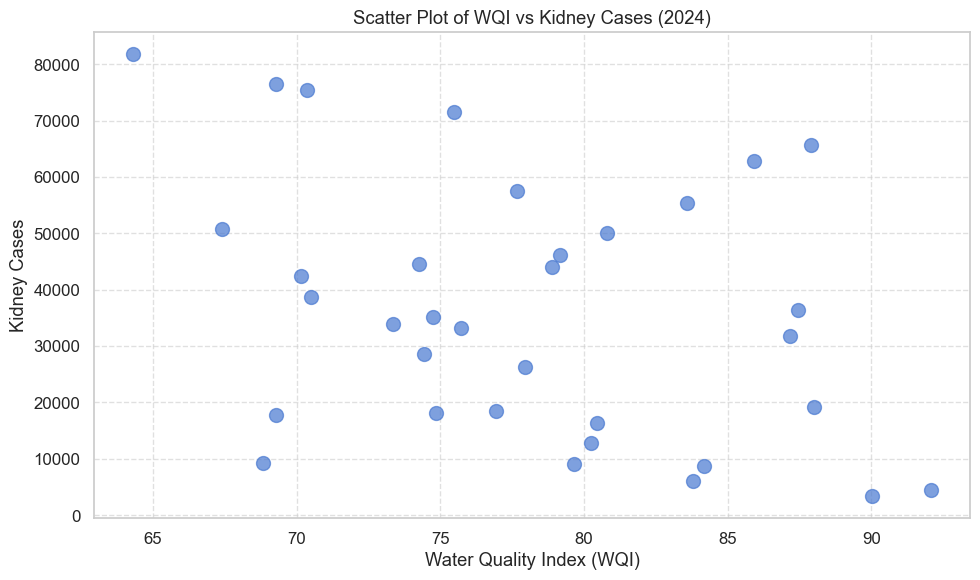

In [42]:
import matplotlib.pyplot as plt

# Scatter plot without state labels
plt.figure(figsize=(10, 6))
plt.scatter(filtered_df["WQI"], filtered_df["kidney_cases"], alpha=0.7, s=100)

plt.title(f"Scatter Plot of WQI vs Kidney Cases ({filtered_df['year'].iloc[0]})")
plt.xlabel("Water Quality Index (WQI)")
plt.ylabel("Kidney Cases")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


C:\Users\urvas\AppData\Local\Temp\ipykernel_3160\1320650360.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["WQI_bin"] = pd.cut(filtered_df["WQI"], bins=bins, labels=labels, include_lowest=True)
C:\Users\urvas\AppData\Local\Temp\ipykernel_3160\1320650360.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = filtered_df.groupby("WQI_bin")["kidney_cases"].mean().reset_index()


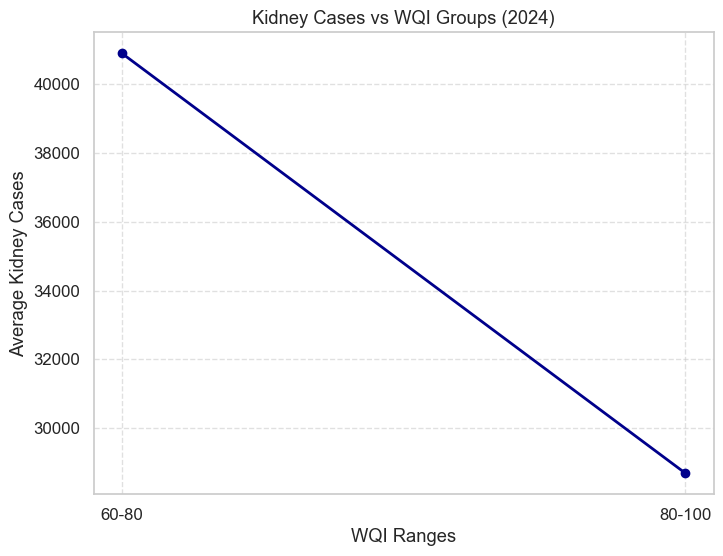

In [43]:


# Bin WQI values
bins = [40, 60, 80, 100, 150, 200]
labels = ["40-60", "60-80", "80-100", "100-150", "150-200"]
filtered_df["WQI_bin"] = pd.cut(filtered_df["WQI"], bins=bins, labels=labels, include_lowest=True)

# Group by bins
grouped = filtered_df.groupby("WQI_bin")["kidney_cases"].mean().reset_index()

# Line plot
plt.figure(figsize=(8,6))
plt.plot(grouped["WQI_bin"], grouped["kidney_cases"], marker="o", linewidth=2, color="darkblue")
plt.title(f"Kidney Cases vs WQI Groups ({filtered_df['year'].iloc[0]})")
plt.xlabel("WQI Ranges")
plt.ylabel("Average Kidney Cases")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


C:\Users\urvas\AppData\Local\Temp\ipykernel_3160\60725560.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["WQI_bin"] = pd.cut(filtered_df["WQI"], bins=bins, labels=labels, include_lowest=True)
C:\Users\urvas\AppData\Local\Temp\ipykernel_3160\60725560.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = filtered_df.groupby("WQI_bin")["kidney_cases"].mean().reset_index()


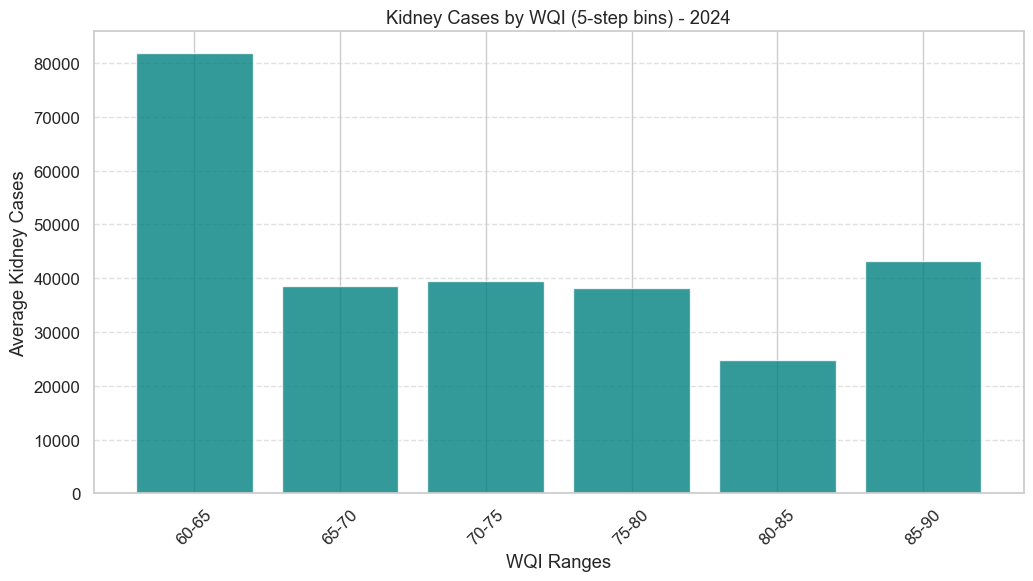

In [44]:


# Create fine bins: 40-45, 45-50, ..., up to 90
bins = np.arange(40, 95, 5)  
labels = [f"{bins[i]}-{bins[i+1]}" for i in range(len(bins)-1)]
filtered_df["WQI_bin"] = pd.cut(filtered_df["WQI"], bins=bins, labels=labels, include_lowest=True)

# Group by bins and calculate average kidney cases
grouped = filtered_df.groupby("WQI_bin")["kidney_cases"].mean().reset_index()

# Bar plot
plt.figure(figsize=(12,6))
plt.bar(grouped["WQI_bin"], grouped["kidney_cases"], color="teal", alpha=0.8)

plt.title(f"Kidney Cases by WQI (5-step bins) - {filtered_df['year'].iloc[0]}")
plt.xlabel("WQI Ranges")
plt.ylabel("Average Kidney Cases")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


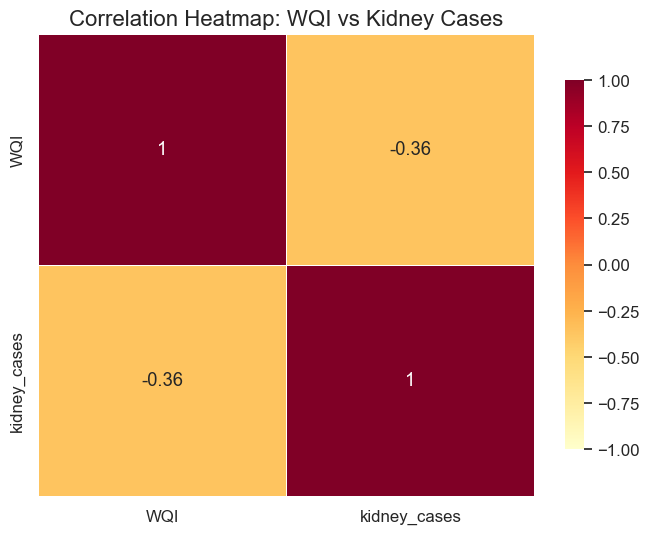

In [53]:
# Correlation matrix for WQI and Kidney Cases
correlation_matrix = filtered_df[['WQI', 'kidney_cases']].corr()

plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, cmap='YlOrRd', vmin=-1, vmax=1,
            linewidths=0.5, cbar_kws={"shrink": 0.8})

plt.title('Correlation Heatmap: WQI vs Kidney Cases', fontsize=16)
plt.show()



## 🌊 Heatmap Analysis: Water Quality Index and Kidney Cases

* The **heatmap** shows a **negative correlation** between the **Water Quality Index (WQI)** and **kidney cases** across different states. 

* This means that as the **WQI increases (better water quality)**, the number of kidney cases **tends to decrease**.

* The **brighter the color** on the heatmap, the **stronger the relationship.** This supports the idea that **poor water quality may be linked to higher kidney related health risks.**

>## Conclusion

In [54]:

# Correlation Calculation
correlation = filtered_df['WQI'].corr(filtered_df['kidney_cases'])
print(f'Correlation between Water Quality Index and Kidney Cases: {correlation:.2f}')

if correlation < -0.5:
    print("There is a strong negative correlation between Water Quality Index and Kidney Cases.")
elif correlation < -0.3:
    print("There is a moderate negative correlation between Water Quality Index and Kidney Cases.")
else:
    print("There is a weak or no significant correlation between Water Quality Index and Kidney Cases.")


Correlation between Water Quality Index and Kidney Cases: -0.36
There is a moderate negative correlation between Water Quality Index and Kidney Cases.
